In [1]:
import os
import sys
import json
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne
from mne.time_frequency import tfr_array_morlet

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [7]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

### Load subjects list from .json file

In [8]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [9]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        print('')

MOs_superficial

 521885
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521886
Experiment type: electrical stimulation
SomnoSuite log file not found.

 521887
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543393
Experiment type: electrical stimulation
SomnoSuite log file not found.

 543394
Experiment type: electrical stimulation
SomnoSuite log file not found.

 546655
Experiment type: electrical and sensory stimulation

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.

 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment t

In [10]:
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EEG_analysis'

### Load EEG traces

In [11]:
## parameters ##
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
apply_car = True
test_states = ['awake', 'anesthetized']
current_level = ['low', 'medium', 'high']

### Test single subject

In [27]:
group = 'MOs_deep'
mouse_num = '571619'
mdata = multi_sub_dict[group][mouse_num]

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
try:
    bad_chs = mdata['bad_chs']
except KeyError:
    badchstr = exp_meta['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
    
## Load stim log ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

## Parse traces into stim types ##
EEG_traces = {}
for leveli, parami in zip(current_level, currents_list):
    EEG_traces[leveli] = {}
    for statei in test_states:
        sweeps = mdata['states'][statei]
        if sweeps:
            state_event_inds = []
            for sweepi in sweeps:
                eventinds = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=chtrials)
                if len(eventinds) == 0:
                    continue
                state_event_inds.append(eventinds)
            state_event_inds = np.concatenate(state_event_inds)
            
            ## Get evoked EEG traces ##
            event_traces = all_EEG_traces[:, :, state_event_inds]
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

            EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]
print(bad_chs)

[2, 3, 4, 5, 13]


### Plot EEG traces

<IPython.core.display.Javascript object>


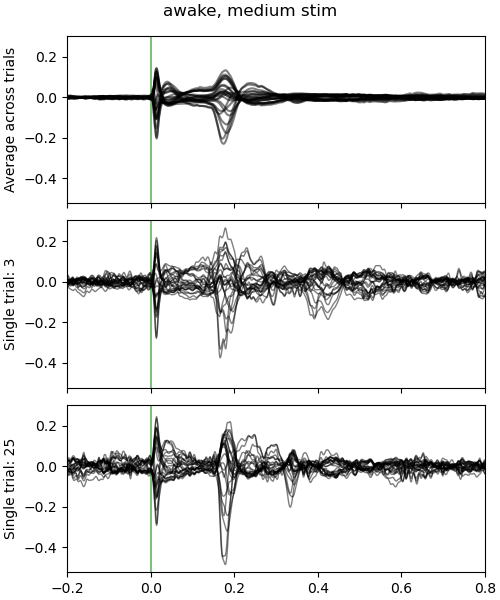

In [42]:
plevel = 'medium'
pstate = 'awake' # 'awake' 'anesthetized'
pwin = [-0.2, 0.8]
# ptrials = np.sort(np.random.choice(np.arange(LFP_traces['MO'][plevel][pstate].shape[2]), 3, replace=False))
ptrials = np.array([3, 25])
timex = EEG_traces[plevel][pstate][0]
traces = EEG_traces[plevel][pstate][1][:, GOOD_CHS, :]

fig, axs = plt.subplots(len(ptrials) + 1, 1, figsize=(5,6), sharex=True, sharey=True, constrained_layout=True)

## Plot average across trials ##
axs[0].axvline(0, color='g', alpha=0.5)
axs[0].plot(timex, np.mean(traces, axis=2)/1E3, 'k', linewidth=1.5, alpha=0.5)
axs[0].set_xlim(pwin)
axs[0].set_ylabel('Average across trials')

for ax, triali in zip(axs[1:], ptrials):
    ax.axvline(0, color='g', alpha=0.5)
    ax.plot(timex, traces[:, :, triali]/1E3, 'k', linewidth=1, alpha=0.5)
    ax.set_ylabel('Single trial: {:d}'.format(triali))

plt.suptitle('{}, {} stim'.format(pstate, plevel))

## Save ##
figname = 'EEGsignals_{}_{}_{}_{}.png'.format(mouse_num, group, pstate, plevel)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Time-frequency analysis

#### Frequency: linear scale

In [36]:
plevel = 'medium'
pstate = 'anesthetized' # 'awake' 'anesthetized'

test_freqs = np.arange(1., 101., 2.)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

timex = EEG_traces[plevel][pstate][0]
traces = EEG_traces[plevel][pstate][1][:, GOOD_CHS, :]

start = time.time()
power = tfr_array_morlet(
    traces.T, sfreq=mdata['exp'].ephys_params['EEG']['sample_rate'],
    freqs=test_freqs, n_cycles=test_ncycles, output='avg_power'
)
## (n_chans, n_freqs, n_times) ##

## Baseline adjust power ##
blpower = mne.baseline.rescale(power, timex, (-1.8, -0.5), mode='logratio', copy=True)
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Applying baseline correction (mode: logratio)
Time to analyze: 1.56 min


<IPython.core.display.Javascript object>


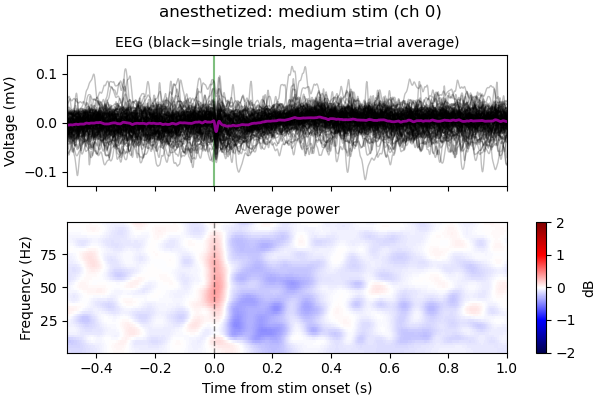

In [41]:
pch = 0
pwin = [-0.5, 1.0]

if pch in GOOD_CHS:
    chind = np.nonzero(GOOD_CHS == pch)[0][0]

    fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, constrained_layout=True)

    ## Plot average across trials ##
    axs[0].axvline(0, color='g', alpha=0.5)
    axs[0].plot(timex, traces[:, chind, :]/1E3, 'k', linewidth=1, alpha=0.25)
    axs[0].plot(timex, np.mean(traces[:, chind, :], axis=1)/1E3, 'm', linewidth=2, alpha=0.75)
    axs[0].set_ylabel('Voltage (mV)')
    axs[0].set_title('EEG (black=single trials, magenta=trial average)')

    ## Plot power ##
    im = axs[1].imshow(
        blpower[chind,:,:], cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-2, vmax=2,
        extent=[timex[0], timex[-1], test_freqs[0], test_freqs[-1]]
    )
    axs[1].axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
    axs[1].set_xlim(pwin)
    cbar = fig.colorbar(im)
    cbar.set_label('dB')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_xlabel('Time from stim onset (s)')
    axs[1].set_title('Average power')

    plt.suptitle('{}: {} stim (ch {:d})'.format(pstate, plevel, pch))

    ## Save ##
    figname = 'EEGpower_{}_{}_{}_{}_ch{:d}.png'.format(mouse_num, group, pstate, plevel, pch)
#     fig.savefig(os.path.join(plotsdir, figname), transparent=True)
else:
    print('Chosen channel is bad')